In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [ ]:
%cd /content/drive/MyDrive/kaggle/

/content/drive/MyDrive/kaggle


In [ ]:
!kaggle datasets download -d theblackmamba31/landscape-image-colorization

landscape-image-colorization.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/drive/MyDrive/kaggle/traffic-signs-preprocessed.zip

Archive:  /content/drive/MyDrive/kaggle/traffic-signs-preprocessed.zip
replace data0.pickle? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
import os
from tqdm.auto import tqdm
from typing import Dict, Tuple, List
import random
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torch.nn.functional as F
from skimage.color import rgb2lab, lab2rgb

In [ ]:
color_path = '/content/drive/MyDrive/kaggle/landscape Images/color/'
gray_path = '/content/drive/MyDrive/kaggle/landscape Images/gray/'

In [ ]:
num_color_image = len(os.listdir(color_path))
rand_idx = random.sample(list(range(num_color_image)),num_color_image)
num_train = round(0.8 * num_color_image)
train_indices = rand_idx[:num_train]
test_indices = rand_idx[num_train:]

In [ ]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, gray_path, color_path, index,transform):
        self.gray_path = gray_path
        self.color_path = color_path
        self.index = index
        self.transform = transform

    def __len__(self):
        return len(self.index)
    def read_and_resize_image(path, img_name, size=(160, 160)):
        image = read_image(path + img_name)
        image = image.unsqueeze(0)
        image = F.interpolate(image, size)
        image = image.squeeze(0)
        return image

    def permute_and_repeat(image):
        image = image.permute(1, 2, 0)
        image = image.repeat(1, 1, 3)
        image = image.permute(2, 0, 1)
        return image

    def convert_to_normalized_lab(image):
        image = torch.tensor(rgb2lab(image.permute(1, 2, 0) / 255))
        image = (image + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])
        return image

    def __getitem__(self, idx):
        img_name = str(idx) + '.jpg'

        image = read_and_resize_image(self.gray_path, img_name)
        image = permute_and_repeat(image)
        image = convert_to_normalized_lab(image)
        image = image.permute(2, 0, 1)
        image = image[:1, :, :]

        label = read_and_resize_image(self.color_path, img_name)
        label = label.permute(1, 2, 0)
        label = label.permute(2, 0, 1)
        label = convert_to_normalized_lab(label)
        label = label.permute(2, 0, 1)
        label = label[1:, :, :]

        return image, label



In [ ]:

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = dataset(gray_path = gray_path,color_path = color_path,  index = train_indices,transform = transform)
test_dataset = dataset(gray_path = gray_path,color_path = color_path,  index = test_indices,transform = transform)

train_dataloader = DataLoader(train_dataset ,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
img, label = next(iter(train_dataloader))
sample_image,sample_label = img[0], label[0]
print(sample_image.shape, sample_label.shape)

torch.Size([1, 160, 160]) torch.Size([2, 160, 160])


Visualize Image

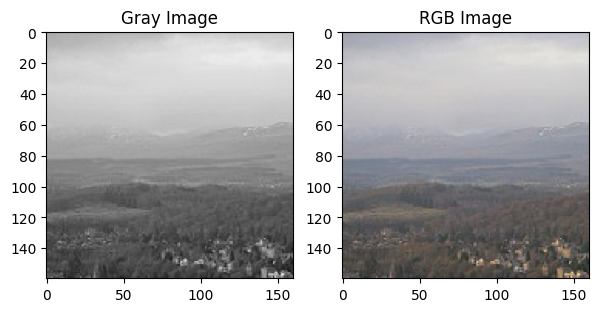

In [ ]:
fig = plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.imshow(sample_image.permute(1,2,0),cmap='gray')
plt.title('Gray Image')

plt.subplot(1,2,2)
RGB_image = torch.cat((sample_image,sample_label),dim=0).permute(1,2,0)
RGB_image = RGB_image * torch.tensor([100,255,255]) -torch.tensor([0,128,128])
RGB_image = lab2rgb(RGB_image)
plt.imshow(RGB_image)
plt.title('RGB Image')
plt.show()

In [ ]:
import torch.nn as nn

class conv_autoencoder(nn.Module):
      def __init__(self):
        """
        Initializes each part of the convolutional neural network.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)

        self.t_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.t_conv1_bn = nn.BatchNorm2d(64)
        self.t_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.t_conv2_bn = nn.BatchNorm2d(32)
        self.t_conv3 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1)

      def forward(self, x):
        """
        Implements the forward pass for the given data `x`.
        :param x: The input data.
        :return: The neural network output.
        """
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))

        x = F.relu(self.t_conv1_bn(self.t_conv1(x)))
        x = F.relu(self.t_conv2_bn(self.t_conv2(x)))
        x = F.relu(self.t_conv3(x))
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
autoencoder = conv_autoencoder()
autoencoder.to(device)

conv_autoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (t_conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (t_conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv3): ConvTranspose2d(32, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """
    This function defines a training step for a PyTorch mode

        Parameters:
                model: A PyTorch model that will be trained.
                dataloader: A PyTorch data loader that provides batches of training data.
                loss_fn: A PyTorch loss function that will be used to calculate the loss.
                optimizer: A PyTorch optimizer that will be used to update the model parameters.
                device: A PyTorch device that specifies where the computation will take place (e.g., "cpu" or "cuda").
        Returns:
               The function returns a tuple containing two values: the average training loss and the average training accuracy for a single epoch.
    """


    model.train()

    train_loss = 0.0
    for batch, (images, labels) in enumerate(train_dataloader):
        images = images.float().to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_dataloader)

    return train_loss


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()

    test_loss = 0.
    with torch.no_grad():
        model.eval()
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()*images.size(0)
    model.train()
    test_loss = test_loss/len(test_dataloader)

    return test_loss


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """
    This function defines the main training loop for a PyTorch model.

        Parameters:
                model: A PyTorch model that will be trained.
                train_dataloader: A PyTorch data loader that provides batches of training data.
                test_dataloader: A PyTorch data loader that provides batches of test data.
                optimizer: A PyTorch optimizer that will be used to update the model parameters.
                loss_fn: A PyTorch loss function that will be used to calculate the loss.
                epochs: An integer specifying the number of training epochs.
                device: A PyTorch device that specifies where the computation will take place (e.g., "cpu" or "cuda").
        Returns:
               The function returns a dictionary containing four lists: the training loss, training accuracy, test loss, and test accuracy for each epoch.
    """
    results = {"train_loss": [],
               "test_loss": []
               }
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f} "
        )

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return results


In [ ]:
results = train(
    autoencoder,
    train_dataloader,
    test_dataloader,
    optimizer,
    criterion,
    epochs=10,
    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2275 | test_loss: 2.0244 
Epoch: 2 | train_loss: 2.0346 | test_loss: 1.9750 
Epoch: 3 | train_loss: 2.0246 | test_loss: 1.9843 
Epoch: 4 | train_loss: 2.0254 | test_loss: 1.9826 
Epoch: 5 | train_loss: 2.0236 | test_loss: 1.9684 
Epoch: 6 | train_loss: 2.0189 | test_loss: 1.9751 
Epoch: 7 | train_loss: 1.9761 | test_loss: 1.8594 
Epoch: 8 | train_loss: 1.8992 | test_loss: 1.8530 
Epoch: 9 | train_loss: 1.8923 | test_loss: 1.8686 
Epoch: 10 | train_loss: 1.8880 | test_loss: 1.8493 


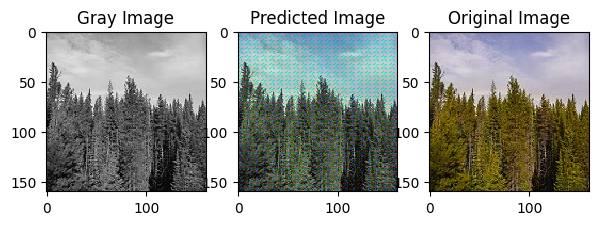

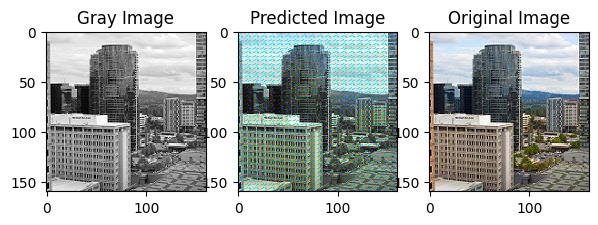

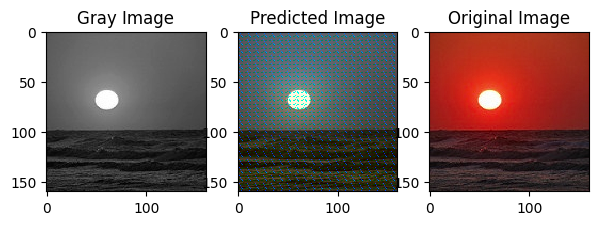

In [ ]:
for i in range(3):
    test_img, test_label = next(iter(test_dataloader))
    pred = autoencoder.forward(test_img[0].float().cuda().view(1, 1, 160, 160))
    lab_pred = torch.cat((test_img[0].view(1, 160, 160), pred[0].cpu()), dim=0)
    lab_pred_inv_scaled = lab_pred.permute(1, 2, 0) * torch.tensor([100, 255, 255]) - torch.tensor([0, 128, 128])
    rgb_pred = lab2rgb(lab_pred_inv_scaled.detach().numpy())

    fig, axs = plt.subplots(1, 3, figsize=(7, 7))

    axs[0].imshow(test_img[0].permute(1, 2, 0), cmap='gray')
    axs[0].set_title('Gray Image')

    axs[1].imshow(rgb_pred)
    axs[1].set_title('Predicted Image')

    color_image = torch.cat((test_img[0], test_label[0]), dim=0).permute(1, 2, 0)
    color_image = color_image * torch.tensor([100, 255, 255]) - torch.tensor([0, 128, 128])
    color_image = lab2rgb(color_image)

    axs[2].imshow(color_image)
    axs[2].set_title('Original Image')

    plt.show()